In [1]:
import os
import sys
import pandas as pd
import numpy as np
import time
import tables
import warnings
from datetime import date, datetime, timedelta
from pvoutput import *
from pvoutput.utils import get_logger, get_dates_already_downloaded, system_id_to_hdf_key
from pvoutput.daterange import safe_convert_to_date

## TODO

* It's possible that some of the dates in the missing_dates table are not actually missing(!)  (There was a period when there was a bug in the code, where it wouldn't always pass the correct requested date to PVOutput.org's API).

In [2]:
BASE_PATH = os.path.expanduser('~/data/pvoutput.org/')

# OUTPUT_TIMESERIES_FILENAME = os.path.join(BASE_PATH, 'UK_PV_timeseries.hdf')
OUTPUT_TIMESERIES_FILENAME = os.path.join(BASE_PATH, 'UK_PV_timeseries_batch.hdf')

INPUT_PV_LIST_FILENAME = os.path.join(BASE_PATH, 'UK_PV_listing_metadata.hdf')
METADATA_FILENAME = os.path.join(BASE_PATH, 'UK_PV_metadata.csv')
PV_STATS_FILENAME = os.path.join(BASE_PATH, 'UK_PV_stats.csv')

START_DATE = pd.Timestamp("1950-01-01")
END_DATE = pd.Timestamp("2019-08-20")

logger = get_logger(stream_handler=False)

In [3]:
pv_systems = pd.read_hdf(INPUT_PV_LIST_FILENAME, 'metadata')

In [4]:
pv_systems['system_capacity_kW'] = pd.to_numeric(pv_systems['system_capacity'].str.replace('kW', ''))
pv_systems.drop('system_capacity', axis='columns', inplace=True)

In [5]:
pv_systems.head()

,Array Tilt,Inverter,Location,Orientation,Panels,Shade,system_name,Outputs,Generation,Average,Efficiency,system_capacity_kw,efficiency_kWh_per_kW,system_1_tilt_degrees,system_2_tilt_degrees,system_capacity_kW
system_id,,,,,,,,,,,,,,,,
26965,11.0°,Enphase M215,United Kingdom CV47,South 0.0°,336x250W Q Cells Pro-G3 250,Low,mfl_phc,1813 days,399.238MWh,220.208kWh,2.654kWh/kW,84.00,2.654,11.0,NaN,84.00
24768,NaN,aurora trio,United Kingdom OX7,South 180.0°,1050x240W qidong,No,mfl_qfa,446 days,307.029MWh,688.405kWh,2.732kWh/kW,252.00,2.732,NaN,NaN,252.00
11542,15.0°,SMA TRI-Power 1700 TL,United Kingdom PE11,South 180.0°,200x250W Emmvee ES 230 M60 B,No,Wray Farms Solar System,2437 days,293.684MWh,120.510kWh,2.477kWh/kW,50.00,2.477,15.0,NaN,50.00
66991,40.0°,Unknown,United Kingdom HR8,South 180.0° / South West 225.0°,152x325W + 80x325W Unknown,No,Ledbury Community Hospital,1434 days,279.902MWh,195.190kWh,2.603kWh/kW,75.40,2.603,40.0,NaN,75.40
5116,15.0°,Fronius CL36; Datamanager 2.0,United Kingdom OX7,South 180.0°,182x235W Q.Base-G2 235,No,mfl_scf,2538 days,267.470MWh,105.386kWh,2.493kWh/kW,42.77,2.493,15.0,NaN,42.77


In [6]:
pv_metadata = pd.read_csv(METADATA_FILENAME, index_col='system_id')

In [7]:
pv_metadata.head()

,system_name,system_size_watts,postcode,number_of_panels,panel_power_watts,panel_brand,num_inverters,inverter_power_watts,inverter_brand,orientation,array_tilt_degrees,shade,install_date,latitude,longitude,status_interval_minutes,number_of_panels_secondary,panel_power_watts_secondary,orientation_secondary,array_tilt_degrees_secondary
system_id,,,,,,,,,,,,,,,,,,,,
19397,AndyT's,3900,BS22,20,195,ZN Shine 195w,1,3500,Kaco 4202,S,30.0,No,2011-11-21 00:00:00,51.36,-2.92,5,0,0,NaN,NaN
8195,Kilmarnock Roof,3750,KA3,15,250,Sanyo 250 HIT,1,4000,Omniksol,S,30.0,No,2011-11-07 00:00:00,55.64,-4.49,10,0,0,NaN,NaN
8200,Flat 5,3430,E8,14,245,NaN,1,3000,sb3000,S,25.0,Low,2011-12-12 00:00:00,51.54,-0.06,5,0,0,NaN,NaN
8204,Sooper-Dooper Solar,2940,GU2,12,245,SunTech STP245S-20/Wd,1,3000,Kaco Powador 3002,S,19.0,No,2012-05-11 00:00:00,51.24,-0.59,10,0,0,NaN,NaN
8205,58GPR,4000,BS48,16,250,Sanyo component Europe GmbH,1,50,Sma sunny boysb3800v,S,NaN,No,2011-11-10 00:00:00,51.42,-2.74,10,0,0,NaN,NaN


In [8]:
pv_systems_joined = (
    pv_systems
    .join(
        pv_metadata[['status_interval_minutes', 'install_date', 'latitude', 'longitude']],
        how='left'
    ))

In [9]:
# Filter 'bad' systems
pv_systems_filtered = pv_systems_joined.query(
    'status_interval_minutes <= 60')

pv_systems_filtered = pv_systems_filtered.dropna(subset=['latitude', 'longitude'])

In [10]:
len(pv_systems_filtered)

2556

In [11]:
pv_systems_filtered.head()

,Array Tilt,Inverter,Location,Orientation,Panels,Shade,system_name,Outputs,Generation,Average,Efficiency,system_capacity_kw,efficiency_kWh_per_kW,system_1_tilt_degrees,system_2_tilt_degrees,system_capacity_kW,status_interval_minutes,install_date,latitude,longitude
system_id,,,,,,,,,,,,,,,,,,,,
26965,11.0°,Enphase M215,United Kingdom CV47,South 0.0°,336x250W Q Cells Pro-G3 250,Low,mfl_phc,1813 days,399.238MWh,220.208kWh,2.654kWh/kW,84.00,2.654,11.0,NaN,84.00,5,2014-01-17 00:00:00,52.230000,-1.380000
24768,NaN,aurora trio,United Kingdom OX7,South 180.0°,1050x240W qidong,No,mfl_qfa,446 days,307.029MWh,688.405kWh,2.732kWh/kW,252.00,2.732,NaN,NaN,252.00,5,2013-07-26 00:00:00,51.910000,-1.520000
11542,15.0°,SMA TRI-Power 1700 TL,United Kingdom PE11,South 180.0°,200x250W Emmvee ES 230 M60 B,No,Wray Farms Solar System,2437 days,293.684MWh,120.510kWh,2.477kWh/kW,50.00,2.477,15.0,NaN,50.00,5,2011-12-08 00:00:00,52.800000,-0.160000
66991,40.0°,Unknown,United Kingdom HR8,South 180.0° / South West 225.0°,152x325W + 80x325W Unknown,No,Ledbury Community Hospital,1434 days,279.902MWh,195.190kWh,2.603kWh/kW,75.40,2.603,40.0,NaN,75.40,15,2015-07-01 00:00:00,52.036331,-2.425194
5116,15.0°,Fronius CL36; Datamanager 2.0,United Kingdom OX7,South 180.0°,182x235W Q.Base-G2 235,No,mfl_scf,2538 days,267.470MWh,105.386kWh,2.493kWh/kW,42.77,2.493,15.0,NaN,42.77,10,2011-12-07 00:00:00,51.945568,-1.385417


In [12]:
pv_systems_filtered.sort_values('system_capacity_kW', ascending=False, inplace=True)
pv_systems_filtered.head()

,Array Tilt,Inverter,Location,Orientation,Panels,Shade,system_name,Outputs,Generation,Average,Efficiency,system_capacity_kw,efficiency_kWh_per_kW,system_1_tilt_degrees,system_2_tilt_degrees,system_capacity_kW,status_interval_minutes,install_date,latitude,longitude
system_id,,,,,,,,,,,,,,,,,,,,
24768,NaN,aurora trio,United Kingdom OX7,South 180.0°,1050x240W qidong,No,mfl_qfa,446 days,307.029MWh,688.405kWh,2.732kWh/kW,252.00,2.732,NaN,NaN,252.00,5,2013-07-26 00:00:00,51.910000,-1.520000
35328,10.0°,samil lake,United Kingdom SA14,South 180.0°,408x245W et,No,Semtek,12 days,90.000kWh,7.500kWh,0.075kWh/kW,99.96,0.075,10.0,NaN,99.96,5,2015-02-20 00:00:00,51.730000,-4.100000
26965,11.0°,Enphase M215,United Kingdom CV47,South 0.0°,336x250W Q Cells Pro-G3 250,Low,mfl_phc,1813 days,399.238MWh,220.208kWh,2.654kWh/kW,84.00,2.654,11.0,NaN,84.00,5,2014-01-17 00:00:00,52.230000,-1.380000
66991,40.0°,Unknown,United Kingdom HR8,South 180.0° / South West 225.0°,152x325W + 80x325W Unknown,No,Ledbury Community Hospital,1434 days,279.902MWh,195.190kWh,2.603kWh/kW,75.40,2.603,40.0,NaN,75.40,15,2015-07-01 00:00:00,52.036331,-2.425194
11542,15.0°,SMA TRI-Power 1700 TL,United Kingdom PE11,South 180.0°,200x250W Emmvee ES 230 M60 B,No,Wray Farms Solar System,2437 days,293.684MWh,120.510kWh,2.477kWh/kW,50.00,2.477,15.0,NaN,50.00,5,2011-12-08 00:00:00,52.800000,-0.160000


In [13]:
# Links to website for manually checking data:
# ['https://pvoutput.org/intraday.jsp?sid={}&dt=20190809'.format(sid) for sid in pv_systems_filtered.index[10:15]]

In [14]:
pv = PVOutput()

In [15]:
logger.info('\n******* STARTING UP ************')

try:
    pv.batch_download(
        system_ids=pv_systems_filtered.index,
        start_date=START_DATE,
        end_date=END_DATE,
        output_filename=OUTPUT_TIMESERIES_FILENAME)
except Exception as e:
    logger.exception('Exception! %s', e)
    raise

 system_id 26965: 3 of 2556 (0.117371%)Request accepted.
Sleeping for 1 minute.


KeyboardInterrupt: 

In [95]:
store = pd.HDFStore(OUTPUT_TIMESERIES_FILENAME, mode='a', complevel=9)

In [30]:
system_id = 26965

In [31]:
ts = store['/timeseries/{}'.format(system_id)]

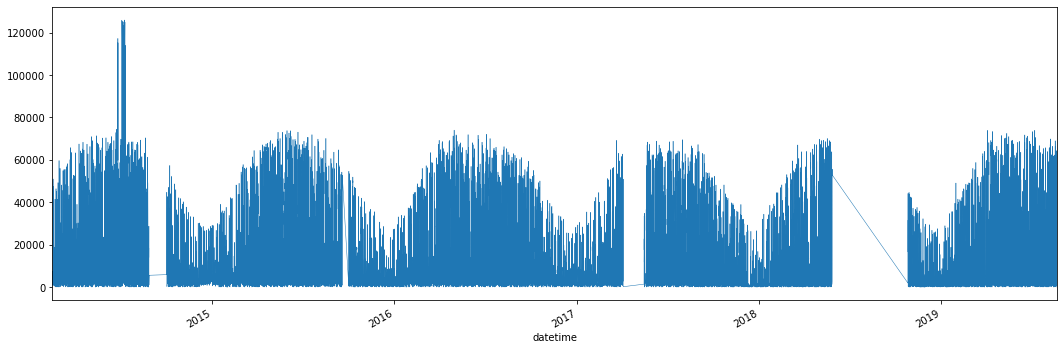

In [32]:
ts['instantaneous_power_gen_W'].plot(figsize=(18, 6), linewidth=0.5);

In [33]:
ts.head()

,cumulative_energy_gen_Wh,instantaneous_power_gen_W,temperature_C,voltage,datetime_of_API_request,query_date
datetime,,,,,,
2014-02-14 07:40:00,0.0,302.0,1.9,NaN,2019-08-24 11:56:16.282958+00:00,2014-08-20
2014-02-14 07:45:00,88.0,1050.0,2.0,NaN,2019-08-31 15:40:53.147874+00:00,2014-09-28
2014-02-14 07:50:00,176.0,1055.0,2.0,NaN,2019-08-24 11:56:16.282958+00:00,2014-08-20
2014-02-14 07:55:00,264.0,1055.0,2.1,NaN,2019-08-24 11:56:16.282958+00:00,2014-08-20
2014-02-14 08:00:00,352.0,1055.0,2.1,NaN,2019-08-24 11:56:16.282958+00:00,2014-08-20


In [34]:
missing = store['missing_dates']

In [38]:
missing

,missing_date_PV_localtime,datetime_of_API_request
pv_system_id,,
24768,2013-10-14,2019-08-24 11:35:19.298597+00:00
24768,2013-10-15,2019-08-24 11:35:19.298597+00:00
24768,2013-10-16,2019-08-24 11:35:19.298597+00:00
24768,2013-10-17,2019-08-24 11:35:19.298597+00:00
24768,2013-10-18,2019-08-24 11:35:19.298597+00:00
...,...,...
7816,2012-04-02,2019-09-01 19:29:26.484576+00:00
7816,2012-04-03,2019-09-01 19:29:26.484576+00:00
7816,2012-04-04,2019-09-01 19:29:26.484576+00:00


In [39]:
ids = np.unique(missing.index)

In [81]:
def get_date_ranges(missing_dates):
    new_missing = []
    missing_dates = np.sort(np.unique(missing_dates))
    gaps = np.diff(missing_dates).astype('timedelta64[D]').astype(int) > 1
    gaps = np.where(gaps)[0]

    start_date = missing_dates[0]
    for gap_i in gaps:
        end_date = missing_dates[gap_i]
        new_missing.append({
            'missing_start_date_PV_localtime': start_date, 
            'missing_end_date_PV_localtime': end_date})
        start_date = missing_dates[gap_i+1]

    end_date = missing_dates[-1]
    new_missing.append({
        'missing_start_date_PV_localtime': start_date, 
        'missing_end_date_PV_localtime': end_date})

    return pd.DataFrame(new_missing)

In [75]:
get_date_ranges(missing_for_id['missing_date_PV_localtime'])

[{'missing_start_date_PV_localtime': numpy.datetime64('2017-02-15T00:00:00.000000000'),
  'missing_end_date_PV_localtime': numpy.datetime64('2018-02-15T00:00:00.000000000')}]

In [80]:
pd.DataFrame(get_date_ranges(
    pd.date_range("2018-01-01", "2018-02-01", freq="D").tolist() +
    pd.date_range("2018-02-05", "2018-02-10", freq="D").tolist()
))

,missing_start_date_PV_localtime,missing_end_date_PV_localtime
1,2018-01-01,2018-02-01
1,2018-02-05,2018-02-10


In [86]:
all_new_missing = []
for system_id in ids:
    missing_for_id = missing.loc[system_id]
    new_missing = get_date_ranges(missing_for_id['missing_date_PV_localtime'])
    new_missing['pv_system_id'] = system_id
    new_missing['datetime_of_API_request'] = missing_for_id['datetime_of_API_request'].iloc[0]
    new_missing.set_index('pv_system_id', inplace=True)
    all_new_missing.append(new_missing)

In [88]:
all_new_missing = pd.concat(all_new_missing)

In [96]:
store.append(
    key='missing_dates',
    value=all_new_missing,
    data_columns=True)

In [97]:
store['missing_dates']

,missing_start_date_PV_localtime,missing_end_date_PV_localtime,datetime_of_API_request
pv_system_id,,,
690,2017-02-15,2018-02-15,2019-08-29 15:24:53.877268+00:00
1222,2010-03-03,2011-03-03,2019-08-29 05:38:44.346230+00:00
1643,2014-01-26,2015-01-26,2019-09-01 00:56:10.268356+00:00
1727,2010-03-24,2011-03-24,2019-08-28 03:02:38.944772+00:00
1802,2010-10-07,2013-10-07,2019-08-27 15:05:01.083825+00:00
...,...,...,...
66567,2018-04-25,2019-04-25,2019-08-31 16:37:35.073286+00:00
66811,2018-04-26,2019-04-26,2019-08-31 18:21:57.127507+00:00
66991,2014-08-03,2019-08-04,2019-08-24 11:58:18.623026+00:00
